In [1]:
import sys
sys.path.append('../')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm, expect_val
from torchqc.operators import Operator
from torchqc.common_matrices import annihilation, creation
from torchqc.dynamics import lindblad_equation, TDSE

* Start from basis state $\psi_0 \otimes \ket{1}$

In [2]:
N = 2 # number of fock states
total_dims = N

fock_state = QuantumState.basis(N)[1]

initial_state = fock_state

* Simulate dynamics

In [3]:
T = 20
Dt = 0.01
wc = 0.1  # cavity frequency
wa = 0.1  # atom frequency
g = 1  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
time = np.arange(0, T, Dt, dtype = np.float32)

* Jaynes-Cummings Hamiltonian under RWA

In [4]:
a_dagger = creation(N)
a = annihilation(N)
N_op = a_dagger * a

H = wc * a_dagger * a

In [5]:
matrices = H.matrix.expand(len(time), -1, -1)
hamiltonian = Operator(total_dims, matrices)

* Simulate dynamics with von-Neumann equation

In [6]:
rho = get_density_matrix(initial_state)
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt)

In [7]:
states[100].matrix

tensor([[0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]], dtype=torch.complex128)

In [8]:
expectation_values = expect_val_dm(states, N_op)

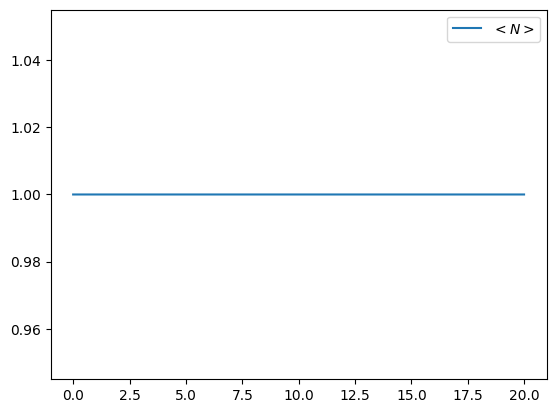

In [9]:
fig, ax = plt.subplots()

plt.plot(time, expectation_values, label=r"$<N>$")
ax.legend()

In [10]:
states = TDSE(initial_state, hamiltonian, time, Dt)
expectation_values = np.array(expect_val(states, N_op), dtype=np.float32)

In [11]:
get_density_matrix(states[100]).matrix

tensor([[0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.9801-0.1987j]], dtype=torch.complex128)

In [12]:
U = Operator(2, torch.linalg.matrix_exp(-1j * H.matrix * 100 * Dt))

new_state = U.mul(initial_state)

new_state.dagger().state_tensor.matmul(new_state.state_tensor)

tensor([[1.+0.j]], dtype=torch.complex128)

In [13]:
torch.matmul(torch.linalg.matrix_exp(-1j * H.matrix * Dt), initial_state.state_tensor)

tensor([[0.0000+0.0000j],
        [1.0000-0.0010j]], dtype=torch.complex128)

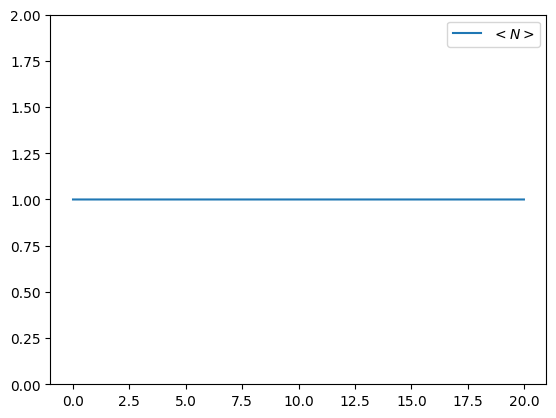

In [14]:
fig, ax = plt.subplots()

plt.plot(time, expectation_values, label=r"$<N>$")
ax.set_ylim(0, 2)
ax.legend()